In [24]:
import pandas as pd

# Load the dataset
file_path = "/Users/marclambertes/Downloads/Outswinger FC - Expected Goals/La Liga xG 04022025.xlsx"
df = pd.read_excel(file_path)

# Filter for even-strength situations (assuming 'Gamestate' indicates game state) 
# and 'Type_of_play' as "RegularPlay"
even_strength_df = df[(df["Gamestate"] == "Draw") & (df["Type_of_play"] == "RegularPlay")]

# Filter for players with at least 5 different dates
players_with_5_dates = even_strength_df.groupby("PlayerId")["Date"].nunique()
valid_players = players_with_5_dates[players_with_5_dates >= 5].index

# Apply the filter to the even_strength_df
filtered_df = even_strength_df[even_strength_df["PlayerId"].isin(valid_players)]

# Compute overall MESH (Mean Even Strength Hazard) using xG values
mesh_value = filtered_df["xG"].mean()

# Compute MESH per team
mesh_per_team = filtered_df.groupby("TeamId")["xG"].mean().reset_index()
mesh_per_team.columns = ["Category", "MESH Value"]
mesh_per_team.insert(0, "Metric", "MESH per Team")

# Compute MESH per player
mesh_per_player = filtered_df.groupby("PlayerId")["xG"].mean().reset_index()
mesh_per_player.columns = ["Category", "MESH Value"]
mesh_per_player.insert(0, "Metric", "MESH per Player")

# Compute MESH per time period (First Half vs. Second Half)
filtered_df["Half"] = filtered_df["timeMin"].apply(lambda x: "First Half" if x <= 45 else "Second Half")
mesh_per_half = filtered_df.groupby("Half")["xG"].mean().reset_index()
mesh_per_half.columns = ["Category", "MESH Value"]
mesh_per_half.insert(0, "Metric", "MESH per Half")

# Compute MESH per shot type (if applicable)
if "ShotQualityModifier" in filtered_df.columns:
    mesh_per_shot_type = filtered_df.groupby("ShotQualityModifier")["xG"].mean().reset_index()
    mesh_per_shot_type.columns = ["Category", "MESH Value"]
    mesh_per_shot_type.insert(0, "Metric", "MESH per Shot Type")
else:
    mesh_per_shot_type = pd.DataFrame(columns=["Metric", "Category", "MESH Value"])  # Empty DataFrame if column doesn't exist

# Create a DataFrame for Overall MESH
overall_mesh_df = pd.DataFrame({"Metric": ["Overall MESH"], "Category": [""], "MESH Value": [mesh_value]})

# Combine all DataFrames into one
mesh_combined = pd.concat([overall_mesh_df, mesh_per_team, mesh_per_player, mesh_per_half, mesh_per_shot_type], ignore_index=True)

# Define Excel file path
output_file = "/Users/marclambertes/Python/MESH_Results_Filtered.xlsx"

# Save results to a single Excel sheet
mesh_combined.to_excel(output_file, sheet_name="MESH Results", index=False)

print(f"\nMESH results saved to: {output_file}")



MESH results saved to: /Users/marclambertes/Python/MESH_Results_Filtered.xlsx


/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_28168/1330916643.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Half"] = filtered_df["timeMin"].apply(lambda x: "First Half" if x <= 45 else "Second Half")


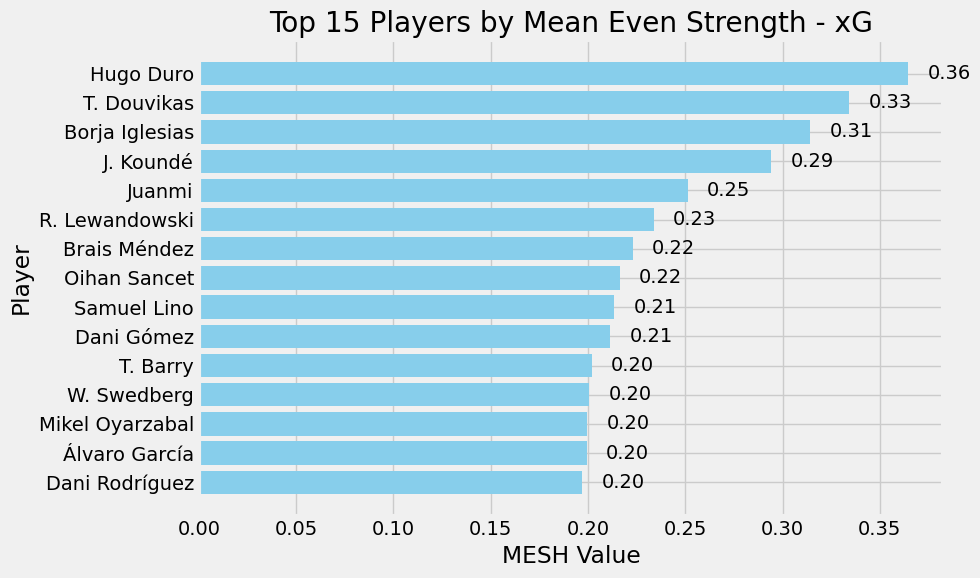

Plot saved as PNG at top_15_players_mesh_plot.png


In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Apply the fivethirtyeight style
plt.style.use('fivethirtyeight')

# Filter for top 15 players based on MESH value
mesh_per_player = mesh_combined[mesh_combined["Metric"] == "MESH per Player"]

# Sort the players by MESH Value in descending order to get the top 15 players with the highest MESH
top_15_players = mesh_per_player.sort_values(by="MESH Value", ascending=False).head(15)

# Create the bar plot with players on the y-axis
plt.figure(figsize=(10, 6))
bars = plt.barh(top_15_players["Category"], top_15_players["MESH Value"], color="skyblue")
plt.xlabel("MESH Value")
plt.ylabel("Player")
plt.title("Top 15 Players by Mean Even Strength - xG")

# Add value labels next to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center', ha='left')

# Reverse the order of players so that the highest MESH value is at the top
plt.gca().invert_yaxis()

# Save the plot as a PNG file
output_file = "top_15_players_mesh_plot.png"
plt.savefig(output_file, format="png", bbox_inches="tight")  # Save as PNG with tight bounding box

# Display the plot
plt.tight_layout()
plt.show()

print(f"Plot saved as PNG at {output_file}")
